#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import catboost as catboost

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn.metrics import make_scorer, mean_squared_error 

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:xlabel='datetime'>

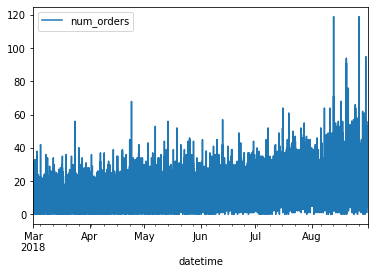

In [4]:
data.plot()

In [5]:
print(data.index.is_monotonic)

True


In [6]:
data=data.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

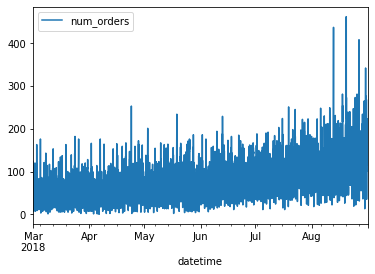

In [7]:
data.plot()

## Анализ

In [8]:
print(data.index.min())
print(data.index.max())
print(data.index.max()-data.index.min())

2018-03-01 00:00:00
2018-08-31 23:00:00
183 days 23:00:00


<AxesSubplot:xlabel='datetime'>

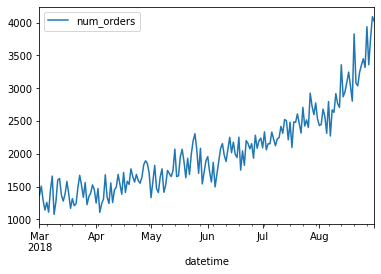

In [9]:
data.resample('1D').sum().plot()

<AxesSubplot:xlabel='datetime'>

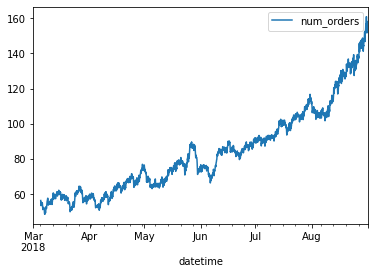

In [10]:
data.rolling(100).mean().plot()

На относительно небольшом временном отрезке сложно отличить месячную сезонность, хотя видна тенденция к увеличению заказов. Зато хорошо видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

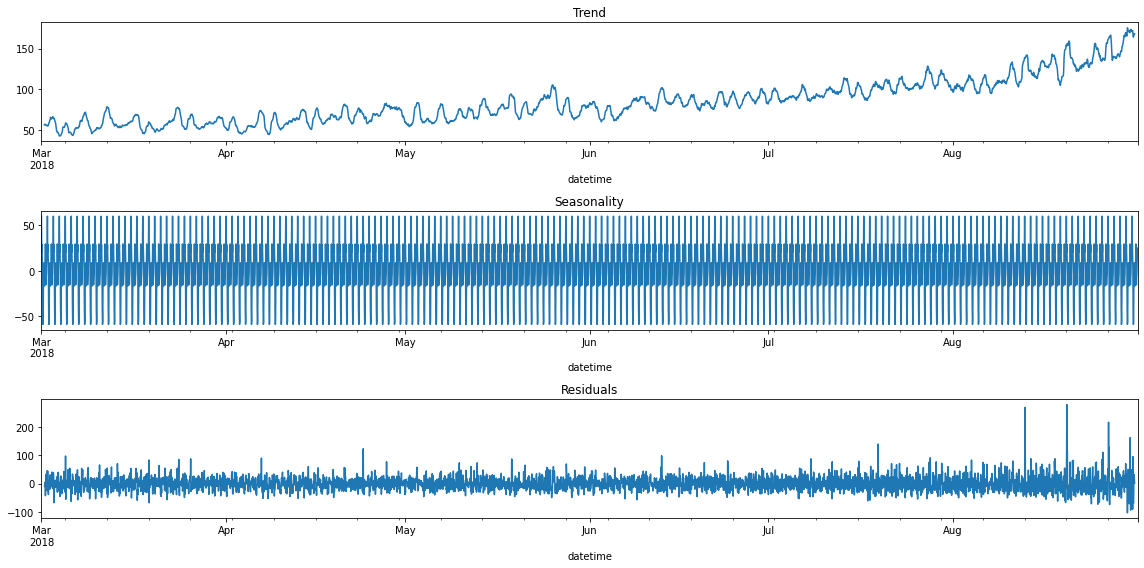

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

## Обучение

In [12]:
def make_features(data,max_lag,roll):
    data['dayofweek']=data.index.dayofweek
    data['hour']=data.index.hour
    for i in range(1,max_lag+1):
        data['lag_{}'.format(i)]=data['num_orders'].shift(i)
    data['rolling_mean']=data['num_orders'].shift().rolling(roll).mean()
make_features(data,24,100)

In [13]:
data=data.dropna()

In [14]:
train,test=train_test_split(data,shuffle=False,test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Функция для подсчета RMSE

In [15]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [16]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression.fit(features_train, target_train)
score = abs(pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean())
print(score)

28.412402437142486


In [17]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
model = RandomForestRegressor()
parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }
forest = GridSearchCV(model,parametrs, scoring=RMSE_score, cv=my_cv)
forest.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f06285f6ba0>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [18]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
cb = catboost.CatBoostRegressor()
cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8427470	total: 47.8ms	remaining: 47.8s
100:	learn: 17.8692599	total: 181ms	remaining: 1.61s
200:	learn: 15.9607824	total: 313ms	remaining: 1.24s
300:	learn: 14.7128169	total: 443ms	remaining: 1.03s
400:	learn: 13.5776480	total: 576ms	remaining: 860ms
500:	learn: 12.6540101	total: 710ms	remaining: 707ms
600:	learn: 11.7146676	total: 849ms	remaining: 563ms
700:	learn: 10.9266052	total: 979ms	remaining: 417ms
800:	learn: 10.2835647	total: 1.11s	remaining: 276ms
900:	learn: 9.6413875	total: 1.24s	remaining: 136ms
999:	learn: 9.0798153	total: 1.37s	remaining: 0us
0:	learn: 31.8817805	total: 2.44ms	remaining: 2.44s
100:	learn: 20.1994746	total: 170ms	remaining: 1.51s
200:	learn: 18.5270027	total: 351ms	remaining: 1.4s
300:	learn: 17.4868682	total: 550ms	remaining: 1.28s
400:	learn: 16.5724681	total: 719ms	remaining: 1.07s
500:	learn: 15.8557860	total: 886ms	remaining: 882ms
600:	learn: 15.2104647	total: 1.06s	remaining: 703ms
700:	learn: 14.6605748	total: 1.22s	remaining: 522ms


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f0618f07a50>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f06288d98b0>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

## Тестирование

In [19]:
regression_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)
print('RMSE ', RMSE(target_test, regression_model_predictions))

RMSE  45.1744169554933


In [20]:
forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=13,
                                     min_samples_leaf =3,
                                     min_samples_split = 4,
                                     n_estimators = 25)
forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)
print('RMSE ', RMSE(target_test, forest_model_predictions))

RMSE  42.79762556535308


In [21]:
cb_model = catboost.CatBoostRegressor(learning_rate=0.03,depth=4)
cb_model.fit(features_train, target_train, verbose=100)
cb_model_predictions = cb_model.predict(features_test)
print('RMSE ', RMSE(target_test, cb_model_predictions))

0:	learn: 38.2170015	total: 3.19ms	remaining: 3.19s
100:	learn: 24.2674485	total: 236ms	remaining: 2.1s
200:	learn: 22.7692978	total: 452ms	remaining: 1.8s
300:	learn: 21.7085475	total: 673ms	remaining: 1.56s
400:	learn: 20.7832879	total: 896ms	remaining: 1.34s
500:	learn: 19.9726626	total: 1.12s	remaining: 1.12s
600:	learn: 19.3182983	total: 1.34s	remaining: 890ms
700:	learn: 18.7501925	total: 1.57s	remaining: 670ms
800:	learn: 18.2674206	total: 1.79s	remaining: 444ms
900:	learn: 17.8233171	total: 2.01s	remaining: 221ms
999:	learn: 17.4163098	total: 2.23s	remaining: 0us
RMSE  40.66470793767463


Лучший показатель RMSE = 40.66 у модели catboost. Отобразим работу модели на линейном графике, чтобы увидеть корректность её работы при сверке с реальными данными.

In [22]:
def model_results(y_true, predictions):
    plt.figure(figsize=(15, 5))
    

    y_true.plot(linewidth=2, color = 'pink', label='Реальные данные')

    predictions_series = pd.Series(predictions[:len(y_true)], index=y_true.index)
    
    predictions_series.plot(linewidth=2, color = 'green', label='Предсказание')

    plt.grid(visible=True, axis='both')
    plt.title(f'Результаты модели за весь период', pad=15, fontsize = 16)
    plt.xlabel('Дата и время')
    plt.ylabel('Число заказов')
    plt.legend(fontsize = 12, loc='upper right')

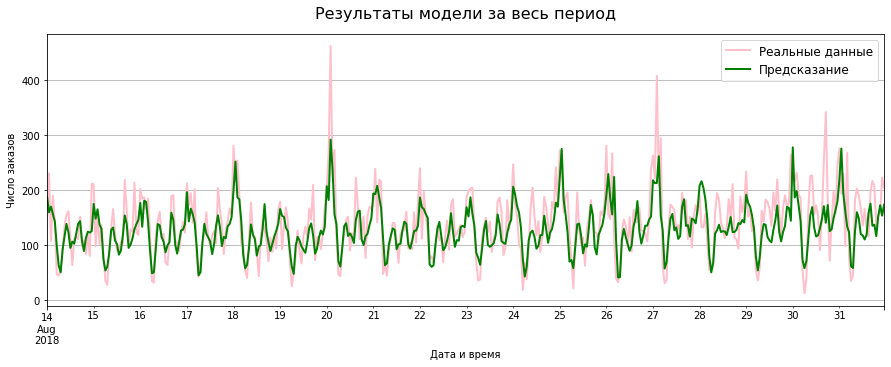

In [23]:
model_results(target_test, cb_model_predictions)